# Extract S0s from dMRI using DiPy

BMED360-2021 `01-dmri-extract-S0s.ipynb`

<a href="https://colab.research.google.com/github/computational-medicine/BMED360-2021/blob/main/Lab3-diffusion-MRI/01-dmri-extract-S0s.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Learning objectives
- Get to know the structure and organisation of dMRI data
- Extract the S0 images from the multichannel dMRI NIFTI file using DiPy

### For using Colab
**--> (some of) the following libraries must be `pip installed` (i.e. uncommet these among the following pip commands):**

In [1]:
#!pip install gdown

In [2]:
#!pip install nilearn

In [3]:
#!pip install dipy

**Download a data file from Google Drive using gdown** (https://github.com/wkentaro/gdown)

In [4]:
import gdown
import shutil
import sys
import os
from os.path import expanduser, join, basename, split
import glob
import shutil
import platform

Check your platform for running this notebook

In [5]:
if platform.system() == 'Darwin':
    print(f'OK, you are running on MacOS ({platform.version()})')
if platform.system() == 'Linux':
    print(f'OK, you are running on Linux ({platform.version()})')
if platform.system() == 'Windows':
    print(f'OK, but consider to install WSL for Windows10 since you are running on {platform.system()}')
    print('Check https://docs.microsoft.com/en-us/windows/wsl/install-win10')

OK, you are running on MacOS (Darwin Kernel Version 20.4.0: Fri Mar  5 01:14:14 PST 2021; root:xnu-7195.101.1~3/RELEASE_X86_64)


In [6]:
cwd = os.getcwd()

In [7]:
working_dir = join(cwd, 'data')
bids_dir = '%s/bids_bg_bmed360' % (working_dir)
dmri_res = '%s/dmri_results' % (working_dir)

In [8]:
# Download zip-file if ./data does not exist (as when running in Colab)

if os.path.isdir(working_dir) == False:
    
    ## Download data.zip for Google Drive            
    # https://drive.google.com/file/d/1pX6Mx_9P8fojDXmbTz-th5FKFYZDVFuO/view?usp=sharing
    file_id = '1pX6Mx_9P8fojDXmbTz-th5FKFYZDVFuO'
    url = 'https://drive.google.com/uc?id=%s' % file_id
    output = './data.zip'
    gdown.download(url, output, quiet=False)
    
    ## Unzip the assets file into `./data`
    shutil.unpack_archive(output, '.')
    
    ## Delete the `data.zip` file
    os.remove(output)
else:
    print(f'./data  exists already!')

./data  exists already!


In [9]:
# Download zip-file if ./data/dmri_results does not exist (as when running in Colab)

if os.path.isdir(dmri_res) == False:
    
    ## Download dmri_results.zip for Google Drive            
    # https://drive.google.com/file/d/1pX6Mx_9P8fojDXmbTz-th5FKFYZDVFuO/view?usp=sharing
    file_id = '1wu5pzAcE2hyZymq-IzuzKYGK_lMYbnJy'
    url = 'https://drive.google.com/uc?id=%s' % file_id
    output = 'dmri_results.zip'
    gdown.download(url, output, quiet=False)
    
    ## Unzip the assets file into `./data/dmri_results`
    shutil.unpack_archive(output, './data/')
    
    ## Delete the `dmri_results.zip` file
    os.remove(output)
else:
    print(f'./data/dmri_results  exists already!')

Downloading...
From: https://drive.google.com/uc?id=1wu5pzAcE2hyZymq-IzuzKYGK_lMYbnJy
To: /Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab3-diffusion-MRI/dmri_results.zip
514MB [00:52, 9.72MB/s] 


In [12]:
import os
from os.path import expanduser, join
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dipy
import nibabel as nib
from dipy.io.image import save_nifti
from dipy.io.image import load_nifti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table

In [13]:
dipy.__version__

'1.4.0'

#  The dMRI data from `Lab3_LG_Prisma_20160218_NIFTI`

In [14]:
dname = join(os.getcwd(), 'data','Lab3_LG_Prisma_20160218_NIFTI')  # NIFTI files
rname = join(os.getcwd(), 'data','dmri_results')  # Results directory

if os.path.isdir(dname) == False:
    print(f'Cannot find your data direcory, are you sure youi have downloded the data? (notebook 00-)')
if os.path.isdir(rname) == False:
    print(f'Makeing the results directory')
    os.makedirs(rname , exist_ok = False)

## Preliminary exploration of the LG_Prisma_20160218 dMRI dataset

In [15]:
dwifn = 'lab3_20160218140906_3_ep2d_diff_qspace_p2'
fn = '%s/%s' % (dname, dwifn)
fdwi = join(dname, '%s.nii.gz' % fn)
fbval = join(dname, '%s.bval' % fn)
fbvec = join(dname, '%s.bvec' % fn)

In [16]:
data, affine, img = load_nifti(fdwi, return_img=True)

`data` is a 4D array where the first 3 dimensions are the i, j, k voxel coordinates 
and the last dimension is the number of non-weighted (S0s) or diffusion-weighted volumes (diffusion sensitizing directions).

In [17]:
print(data.shape)

(100, 100, 60, 129)


Check the dimensions of each voxel

In [18]:
print(img.header.get_zooms()[:3])

(2.2, 2.2, 2.2)


In [19]:
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)

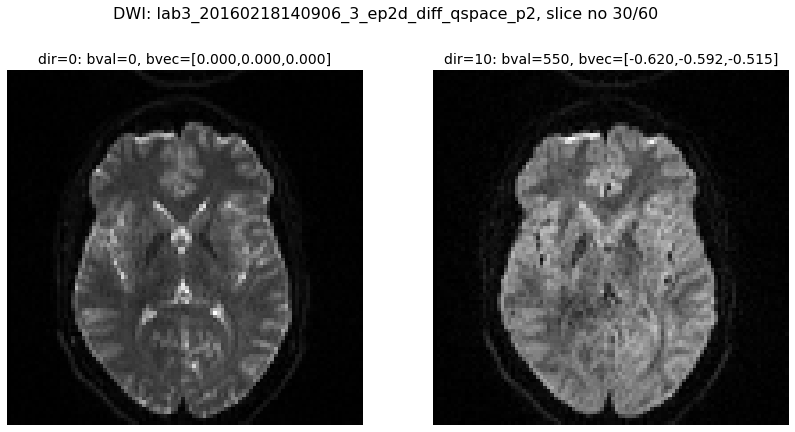

In [20]:
# Inspect data

plt.rcParams["figure.figsize"] = (14,7)

b1 = 0
b2 = 10
axial_middle = data.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(data[:, :, axial_middle, b1].T, cmap='gray', origin='lower')
plt.title('dir=%d: bval=%.0f, bvec=[%.3f,%.3f,%.3f]' % (b1, bvals[b1], bvecs[b1][0],bvecs[b1][1], bvecs[b1][2]), size=14)
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(data[:, :, axial_middle, b2].T, cmap='gray', origin='lower')
plt.title('dir=%d: bval=%.0f, bvec=[%.3f,%.3f,%.3f]' % (b2, bvals[b2], bvecs[b2][0],bvecs[b2][1], bvecs[b2][2]), size=14)
plt.suptitle('DWI: %s, slice no %d/%d' % (dwifn, axial_middle, data.shape[2]), size=16)
plt.savefig('./assets/Lab3_LG_Prisma_20160218_dipy_data.png', bbox_inches='tight')
plt.show()

In DIPY, we use an object called `GradientTable` which holds all the acquisition specific parameters, e.g. b-values, b-vectors, timings and others. 

In [21]:
gtab = gradient_table(bvals, bvecs)

In [22]:
print(gtab.bvals)

[   0.  200.  200.  200.  400.  350.  400.  400.  400.  350.  550.  550.
  550.  550.  750.  750.  750.  950.  950.  950.  950.  950.  950.  950.
  950.  950.  950.  950.  950. 1100. 1100. 1150. 1100. 1100. 1150. 1150.
 1100. 1100. 1150. 1100. 1100. 1500. 1500. 1500. 1500. 1500. 1500. 1700.
 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700.
 1700. 1700. 1850. 1850. 1900. 1850. 1900. 1850. 1850. 1900. 1900. 1850.
 1850. 1850. 2050. 2050. 2050. 2050. 2050. 2050. 2050. 2050. 2050. 2050.
 2050. 2050. 2250. 2250. 2250. 2250. 2450. 2450. 2450. 2400. 2450. 2450.
 2450. 2450. 2450. 2400. 2450. 2450. 2600. 2600. 2600. 2600. 2650. 2600.
 2600. 2650. 2600. 2600. 2600. 2600. 2600. 2600. 2600. 2600. 2650. 2600.
 2600. 2650. 2600. 2600. 2600. 2600. 3000. 3000. 3000.]


In [23]:
# Display first 5 bvecs
print(gtab.bvecs[:5, :])

[[ 0.00000e+00  0.00000e+00  0.00000e+00]
 [-2.00991e-06 -1.00000e+00 -2.49706e-05]
 [-7.46485e-02 -2.11623e-02 -9.96985e-01]
 [ 9.97159e-01 -1.06073e-02 -7.45820e-02]
 [-7.00890e-01 -7.10899e-01  5.81085e-02]]


`gtab.b0s_mask` can be used to tell what part of the data is the S0 volumes (volumes which correspond to b-values of 0)

In [24]:
S0s = data[:, :, :, gtab.b0s_mask]

In [25]:
print(S0s.shape)
print(S0s.shape[-1])

(100, 100, 60, 1)
1


We save this in a new NIFTI file in the `results` directory

In [26]:
fnS0s = join(rname, '%s_dwi_S0.nii.gz' % dwifn)
save_nifti(fnS0s, S0s, affine)

## Define function `extract_S0s`

In [27]:
from dipy.io.image import load_nifti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.io.image import save_nifti

def extract_S0s(inpdir, dwifn, outdir):
    """
    Extract S0s from dwi file
    Usage:
    Ex: 
    """
    
    fdwi = join(inpdir, '%s.nii.gz' % dwifn)
    #print(fdwi)
    fbval = join(inpdir, '%s.bval' % dwifn)
    fbvec = join(inpdir, '%s.bvec' % dwifn)
    
    bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
    gtab = gradient_table(bvals, bvecs)
    data, affine, img = load_nifti(fdwi, return_img=True)
    S0s = data[:, :, :, gtab.b0s_mask]
    nS0s = S0s.shape[-1]
    
    fnS0s = join(outdir, '%s_dwi_S0.nii.gz' % dwifn)
    save_nifti(fnS0s, S0s, affine)
    
    return S0s, affine, nS0s

In [28]:
# Testing function for single subject, single examination

S0s, affine, nS0s = extract_S0s(dname, dwifn, rname)
print('affine:\n', affine)
print('nS0s:', nS0s)

affine:
 [[-2.19293380e+00  8.67084715e-09  1.76185533e-01  1.06019615e+02]
 [-2.77641532e-03  2.19972682e+00 -3.45574021e-02 -7.04481506e+01]
 [ 1.76163644e-01  3.46687585e-02  2.19266152e+00 -4.71965027e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
nS0s: 1


In [29]:
# In case number of S0 images is > 1, we will take the mean
S0s_mean = S0s.mean(axis=-1)
nS0s = S0s.shape[-1]
print('S0s.shape:', S0s.shape)
print('S0s_mean.shape:', S0s_mean.shape)
print('nS0s:', nS0s)

fnS0s_mean = join(rname, '%s_dwi_S0_mean_of_%d.nii.gz' % (dwifn, nS0s))
# save_nifti(fnS0s_mean, S0s_mean, affine)   Not relevant to save in outr case with nS0s = 1

S0s.shape: (100, 100, 60, 1)
S0s_mean.shape: (100, 100, 60)
nS0s: 1


In [30]:
#!freeview -v ./data/dmri_results/lab3_20160218140906_3_ep2d_diff_qspace_p2_dwi_S0.nii.gz

#  The dMRI data from the `bids_bg_bmed360` sample

### Define function `bids_extract_S0s` for the BIDS organized sample

In [31]:
def bids_extract_S0s(inpdir, sub, ses, outdir):
    """
    Extract S0s from dwi file
    Usage:
    Ex: 
    """
    
    fn = 'sub-%d/ses-%d/dwi/sub-%d_ses-%d_dwi' % (sub, ses, sub, ses)
    fdwi = join(inpdir, '%s.nii.gz' % fn)
    #print(fdwi)
    fbval = join(inpdir, '%s.bval' % fn)
    fbvec = join(inpdir, '%s.bvec' % fn)
    
    bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
    gtab = gradient_table(bvals, bvecs)
    data, affine, img = load_nifti(fdwi, return_img=True)
    S0s = data[:, :, :, gtab.b0s_mask]
    nS0s = S0s.shape[-1]
    
    fnS0s = join(outdir, 'sub_%d_tp%d_dwi_S0.nii.gz' % (sub, ses))
    save_nifti(fnS0s, S0s, affine)
    
    return S0s, affine, nS0s

**Testing function for single subject, single examination**

In [32]:
inpdir = bids_dir
sub = 102
ses = 1
outdir = dmri_res

S0s, affine, nS0s = bids_extract_S0s(inpdir, sub, ses, outdir)
print('affine:\n', affine)
print('\nnS0s:', nS0s)

affine:
 [[-1.71879995e+00 -1.04905921e-03  5.71428565e-04  1.13637230e+02]
 [-9.96618648e-04  1.71841156e+00  5.10816313e-02 -8.59372635e+01]
 [ 4.19629563e-04 -3.65607664e-02  2.39945722e+00 -9.88118267e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

nS0s: 6


In [33]:
# In case number of S0 images is > 1, we will take the mean
S0s_mean = S0s.mean(axis=-1)
nS0s = S0s.shape[-1]
print('S0s.shape:', S0s.shape)
print('S0s_mean.shape:', S0s_mean.shape)
print('nS0s:', nS0s)

fnS0s_mean = join(outdir, 'sub_%d_tp%d_dwi_S0_mean_of_%d.nii.gz' % (sub, ses, nS0s))
save_nifti(fnS0s_mean, S0s_mean, affine)

S0s.shape: (128, 128, 50, 6)
S0s_mean.shape: (128, 128, 50)
nS0s: 6


In [34]:
#!freeview -v ./data/dmri_results/sub_102_tp1_dwi_S0_mean_of_6.nii.gz

In [35]:
#!fsleyes ./data/dmri_results/sub_102_tp1_dwi_S0_mean_of_6.nii.gz

In [36]:
S0s_mean = nib.load(fnS0s_mean)

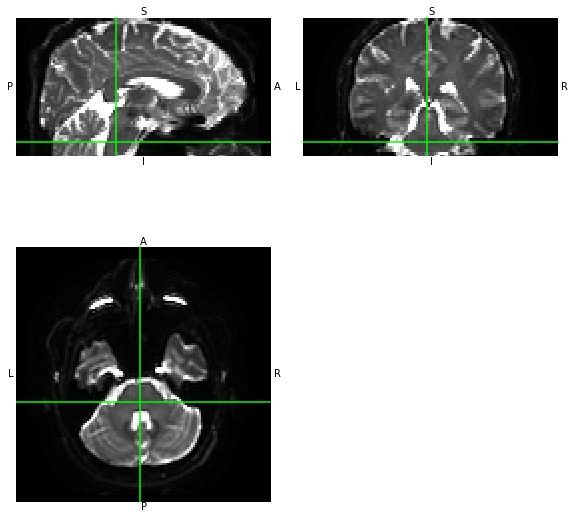

In [37]:
# Viewer from `nibabel`
nib.viewers.OrthoSlicer3D(S0s_mean.get_fdata(), affine=S0s_mean.affine).show()

### Run for all subjects in BIDS sample, having dMRI in ses-1 only

In [38]:
%%time
inpdir = bids_dir
outdir = dmri_res
ses=1

for sub in [102, 103, 111, 123]:
    
    S0s, affine, nS0s = bids_extract_S0s(inpdir, sub, ses, outdir)
    
    S0s_mean = S0s.mean(axis=-1)
    nS0s = S0s.shape[-1]
    fnS0s_mean = join(outdir, 'sub_%d_tp%d_dwi_S0_mean.nii.gz' % (sub, ses))
    save_nifti(fnS0s_mean, S0s_mean, affine)
    

CPU times: user 2.05 s, sys: 99.5 ms, total: 2.15 s
Wall time: 2.17 s
